In [6]:
import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np; np.set_printoptions(threshold=sys.maxsize)

TOTAL_ROWS= 2228278
INPUT_ROWS_LIMIT= TOTAL_ROWS # TOTAL_ROWS
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATION_ID= 117
SECS_IN_5MIN= 300
DATAPOINTS_PER_DAY= 288
DAYS_OF_WEEK= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # yes, I consider Monday to be the '0'/start of the week
STARTING_DAY= 4
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1]
TOTAL_DAYS= 91
OPEN_HOURS= 24 # want to change this to 18 i.e. excluding 1, 2, 3, and 4 am
MAX_DISPLAYED_STATIONS= 1
MAX_DISPLAYED_DAYS= 10
MAX_TIME= int((datetime.datetime(2020,4,2,0,0) - datetime.datetime(2020,1,1,0,0)).total_seconds() / SECS_IN_5MIN)

class DataDay: # ideally this would be nested in the Station class
    def __init__(self, index):
        self.index= index
        self.day_of_week= -1
        self.day_since_epoch= -1
        self.daily_epoch_time= np.zeros(shape= DATAPOINTS_PER_DAY)
        self.epoch_time= np.zeros(shape= DATAPOINTS_PER_DAY)
        self.percent_bikes= np.zeros(shape= DATAPOINTS_PER_DAY)

    def populate(self, daily_epoch_time, epoch_time, percent_bikes):
        self.day_of_week= (STARTING_DAY + int(epoch_time / DATAPOINTS_PER_DAY)) % len(DAYS_OF_WEEK)
        self.day_since_epoch= 1 + int(epoch_time / DATAPOINTS_PER_DAY)
        self.daily_epoch_time[daily_epoch_time]= daily_epoch_time
        self.epoch_time[daily_epoch_time]= epoch_time
        self.percent_bikes[daily_epoch_time]= percent_bikes

class Station:
    def __init__(self, index):
        self.index= index
        self.name= -1
        self.bike_capacity= -1 # populating these attributes with -1 initially as a debugging means
        self.address= -1
        self.latitude= -1
        self.longitude= -1
        self.data_days= [DataDay(i) for i in range(1, TOTAL_DAYS + 3)] # Admitedly, I don't even know exactly why this has to be +3
    
    def populate_consts(self, name, bike_capacity, address, latitude, longitude):
        self.name= name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

def get_station_id(name):
    try:
        index= [x.name for x in stations].index(name)
    except ValueError:
        index= -1
    return index

In [2]:
total_capacity= 0

index= []; daily_epoch_time= []; epoch_time= []; percent_bikes= [];
stations= [Station(i) for i in range(1, MAX_STATION_ID + 1)] # note: MAX_STATION_ID + 1 is not included in the range
indices_to_populate= list(range(1, MAX_STATION_ID + 1))
for index in MISSING_STATIONS:
    indices_to_populate.remove(index)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip data header
    current_index= 0
    try:
        while len(indices_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_index: # this 'if' is just for performance
                continue
            current_index= int(row[0])
            if current_index in indices_to_populate:
                stations[current_index - 2].populate_consts(row[3], row[4], row[8], row[9], row[10])
                indices_to_populate.remove(current_index)
                total_capacity+= int(row[4])
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip data header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            try:
                epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(2020,1,1,0,0)).total_seconds() / (SECS_IN_5MIN + 1)) # the unit of epoch_time is 5-minutes # the + 1 is a means to decrement the results
                stations[int(row[0]) - 1].data_days[int(epoch_time / DATAPOINTS_PER_DAY) + 1].populate( \
                    int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / (SECS_IN_5MIN + 1)), \
                    epoch_time, \
                    float("{:.3f}".format(float(row[6]) / float(row[4]))))
            except IndexError as e:
                print("\nTRIED: ", epoch_time, ' / ', DATAPOINTS_PER_DAY, ' = ', int(epoch_time / DATAPOINTS_PER_DAY))
                print(row[1])
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))

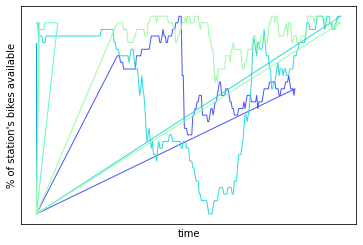

In [3]:
def station_graph(index):
    if MAX_DISPLAYED_DAYS < TOTAL_DAYS:
        colors= cm.rainbow(np.linspace(0, 1, MAX_DISPLAYED_DAYS))
    else:
        colors= cm.rainbow(np.linspace(0, 1, TOTAL_DAYS))

    for (day_i, day), c in zip(enumerate(stations[index].data_days), colors): # use day_i + 1 to access days because day 0 is empty but kept so that the day's date works as an array index too
        if day_i >= MAX_DISPLAYED_DAYS:
            break
        #plt.scatter(station.daily_epoch_time, station.percent_bikes, 1, marker="*", color= c, linewidth=0.0001)
        plt.plot(day.daily_epoch_time, day.percent_bikes, 1, color= c, linewidth=1)
    plt.ylabel('% of station\'s bikes available')
    plt.xlabel('time')
    plt.xticks(())
    plt.yticks(())

    plt.show()

    #plt.scatter(daily_epoch_time, percent_bikes,  color='black')

station_graph(get_station_id('PORTOBELLO ROAD'))

In [8]:
# Approach 01 - Data Prep

time= int((datetime.datetime(2020, 1, 1, 6, 25) - datetime.datetime(2020, 1, 1, 0, 0)).total_seconds() / SECS_IN_5MIN)
station_index_decrement= 1 # this is a varying offset for the indexing of stations that accounts for missing stations that are being ignored
fullness= np.zeros((MAX_TIME - time, MAX_STATION_ID - len(MISSING_STATIONS)), dtype=np.float)
#bikes_changes_past5
#bikes_changes_past15
#bikes_changes_past45
day_of_week= np.zeros((MAX_TIME - time, len(DAYS_OF_WEEK)), dtype=np.int)
hour_of_day= np.zeros((MAX_TIME - time, OPEN_HOURS), dtype=np.float)

for epoch_day_i in range(TOTAL_DAYS):
    for station in stations:
        #print("## STATION")
        if station.index == 1:
            station_index_decrement= 0
        if station.index in MISSING_STATIONS:
            station_index_decrement+= 1
            continue
        block= station.data_days[epoch_day_i].percent_bikes
        block= np.reshape(block, (288, 1))
        x= epoch_day_i * DATAPOINTS_PER_DAY
        y= station.index - station_index_decrement
        fullness[x:x + block.shape[0], y:y + block.shape[1]]= block
        
        block= np.zeros((DATAPOINTS_PER_DAY, len(DAYS_OF_WEEK)), dtype=np.int)
        day= (epoch_day_i + 2) % len(DAYS_OF_WEEK) # Jan 1st is a wednesday, so need to add 2 to make it so
        for block_i, sub_arr in enumerate(block):
            block[block_i][day]= 1
        y= 0
        day_of_week[x:x + block.shape[0], y:y + block.shape[1]]= block
        
        block= np.zeros((DATAPOINTS_PER_DAY, OPEN_HOURS), dtype=np.float)
        for time_i in range(DATAPOINTS_PER_DAY):
            hour= float("{:.3f}".format(time_i / 12))
            #print(hour)
            block[time_i][int(hour) - 1]= 1 - (hour % 1)
            block[time_i][int(hour)]= hour % 1
        hour_of_day[x:x + block.shape[0], y:y + block.shape[1]]= block
print(hour_of_day)

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.083 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.917]
 [0.167 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.833]
 [0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.75 ]
 [0.333 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.667]
 [0.417 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.583]
 [0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0. 